# Develop an automated and scalable process to obtain the average of each five days (moving average) of the price of bitcoin in the first quarter of 2022

## 1 - Explore crypto api 

#### https://www.coingecko.com/en/api/documentation

## 2 - Get a list of all coins, with id, name and symbol, using crypto api, and get the bitcoin id

In [1]:
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import requests
import sqlite3
from datetime import date, datetime

In [2]:
log_format = "%(asctime)s::%(levelname)s::%(name)s::""%(filename)s::%(lineno)d::%(message)s"
logging.basicConfig(filename='./logs/coingecko_full.log', level='DEBUG', format=log_format)

### Extract 

In [3]:
def get_coin_list():
    """Gets a list of coins from the coingecko api, and returns a dataframe with a list of coins, requieres pandas as pd and requests"""
    #We could save the data as a json with
    #list_of_coins.to_json('coin_list.json', orient='records',lines=True)
    
    coins_url = 'https://api.coingecko.com/api/v3/coins/list'
    
    try:
        request = requests.get(coins_url)
        coins = request.json()
        list_of_coins = pd.json_normalize(coins)
    except requests.exceptions.RequestException as e:
        logging.info(f"Exception - {e} occured")
        return
    finally:
        status = None
        if request.status_code != 200:
            status = "FAIL"
            logging.info(f"List of coins : {status}")
        else:
            status = "PASS"
            logging.info(f"List of coins : {status}")
    list_of_coins.to_csv('./data/list_of_coins/list_of_coins.csv', index=False)

    return list_of_coins
    

In [4]:
get_coin_list.__doc__

'Gets a list of coins from the coingecko api, and returns a dataframe with a list of coins, requieres pandas as pd and requests'

In [5]:
coins = get_coin_list()

In [6]:
coins

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0vix-protocol,vix,0VIX Protocol
3,0x,zrx,0x Protocol
4,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract
...,...,...,...
9986,zynergy,zyn,Zynergy
9987,zyro,zyro,Zyro
9988,zyrri,zyr,Zyrri
9989,zyx,zyx,ZYX


### 2.1 - Get bitcoin id

In [7]:
bitcoin_id = coins.loc[coins['name']=='Bitcoin','id'].values[0]

In [8]:
bitcoin_id

'bitcoin'

## 3 - Get the price of bitcoin in usd and by date of the first quarter of 2022 (01/01/2022 - 31/03/2022) (using the crypto api)

In [9]:
def get_coin_price(ini = '01-01-2022', end = '31-03-2022'):
    """Takes two utc dates in the format dd-mm-yyyy and gets historic prices from the coingecko api, and returns them in a dataframe, grouped by date, requires pandas as pd, requests and datetime"""
    
    btc_start_date = int(datetime.strptime('28-04-2013', "%d-%m-%Y").timestamp())
    current_timestamp = int(datetime.now().timestamp())
    
    ini_timestamp = int(datetime.strptime(ini, "%d-%m-%Y").timestamp())
    end_timestamp = int(datetime.strptime(end, "%d-%m-%Y").timestamp())
    
    status = None
    
    if ini_timestamp < btc_start_date:
        ini_timestamp = btc_start_date
    
    if end_timestamp > current_timestamp:
        end_timestamp = current_timestamp

    try:
        coin_url = f'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from={ini_timestamp}&to={end_timestamp}&precision=2'
        request = requests.get(coin_url)
        coin_historic_prices_json = request.json()
    
    except requests.exceptions.RequestException as e:
        logging.info(f"Exception - {e} occured")
    
    finally:
        if request.status_code != 200:
            status = "FAIL"
            logging.info(f"get_coin_price : {status}")
        else:
            status = "PASS"
            logging.info(f"get_coin_price : {status}")
    
    return coin_historic_prices_json

In [10]:
get_coin_price.__doc__

'Takes two utc dates in the format dd-mm-yyyy and gets historic prices from the coingecko api, and returns them in a dataframe, grouped by date, requires pandas as pd, requests and datetime'

In [11]:
bitcoin_price_json = get_coin_price()

In [12]:
bitcoin_price_json

{'prices': [[1641016948259, 47372.2],
  [1641020554453, 47128.85],
  [1641024444418, 47292.78],
  [1641028659948, 47251.88],
  [1641031594501, 47223.1],
  [1641035011717, 46983.08],
  [1641038631867, 46910.84],
  [1641042646920, 47197.89],
  [1641045895812, 47061.03],
  [1641049626547, 46990.94],
  [1641052817098, 47415.36],
  [1641056589028, 47349.33],
  [1641060391580, 48033.25],
  [1641063806923, 47648.66],
  [1641067608314, 47369.35],
  [1641071167074, 47490.07],
  [1641074623890, 47340.45],
  [1641078262034, 47506.77],
  [1641081678106, 47816.08],
  [1641085455216, 47692.34],
  [1641088958452, 47375.63],
  [1641092406399, 47482.14],
  [1641096279489, 47413.91],
  [1641100440898, 46756.9],
  [1641103213354, 47119.61],
  [1641107034655, 47261.45],
  [1641110697630, 47201.76],
  [1641114430671, 47259.22],
  [1641117895895, 47409.45],
  [1641121380870, 47298.51],
  [1641125055064, 47302.32],
  [1641128615044, 47407.28],
  [1641132089524, 47230.03],
  [1641135616995, 47186.15],
  [1641

In [ ]:
#bitcoin_price_other_date_json = get_coin_price(ini = '01-01-2009', end = '31-03-2022')

In [ ]:
#bitcoin_price_other_date_json

#### Transform

In [13]:
def coin_price_formatter(coin_historic_prices_json):
    """Converts a json historic price to a dataframe and returns daily data"""
    
    coin_price_df = pd.DataFrame(coin_historic_prices_json['prices'], columns =['utc_epoch', 'usd_price'])
    
    coin_price_df['utc_epoch'] = pd.to_numeric(coin_price_df['utc_epoch'], errors='coerce')
    coin_price_df['usd_price'] = pd.to_numeric(coin_price_df['usd_price'], errors='coerce')
    coin_price_df.dropna(how='any', inplace=True)
    
    coin_price_df['utc_datetime'] = pd.to_datetime(coin_price_df['utc_epoch'], unit='ms').dt.date
    coin_price_df.drop(['utc_epoch'], axis = 1, inplace = True)
    
    coin_price_df = coin_price_df.groupby(['utc_datetime']).mean().reset_index()
    coin_price_df['usd_price'] = coin_price_df['usd_price'].round(2)
    
    logging.info(f"coin_price_formatter processed {len(coin_price_df)} records")
    coin_price_df.to_csv('./data/price_of_coins/coin_price.csv', index=False)
    
    return coin_price_df

In [14]:
bitcoin_price = coin_price_formatter(bitcoin_price_json)

In [15]:
bitcoin_price

,utc_datetime,usd_price
0,2022-01-01,47309.21
1,2022-01-02,47317.14
2,2022-01-03,46891.53
3,2022-01-04,46498.01
4,2022-01-05,45971.16
...,...,...
85,2022-03-27,44854.32
86,2022-03-28,47226.49
87,2022-03-29,47497.49
88,2022-03-30,47230.60


In [ ]:
#bitcoin_price_other_date_df = coin_price_formatter(bitcoin_price_other_date_json)

In [ ]:
#bitcoin_price_other_date_df

### 3.1 Save the data to a DB, sqlite for demonstration

### 3.1.1 Save coinlist to db coingecko.coin_list

#### Load

In [16]:
conn = sqlite3.connect('./db/coingecko')
c = conn.cursor()

In [17]:
c.execute('CREATE TABLE IF NOT EXISTS coin_list (id, symbol, name)')
conn.commit()

In [18]:
coins.to_sql('coin_list', conn, if_exists='replace')

9991

### 3.1.2 Save bitcoin_price to db congecko.bitcoin_price_hist

In [19]:
c.execute('CREATE TABLE IF NOT EXISTS bitcoin_price_hist (utc_datetime, usd_price)')
conn.commit()

In [20]:
bitcoin_price.to_sql('bitcoin_price_hist', conn, if_exists='replace')

90

If we are going to query more data we should change if_exists = 'append'

## 4- Read the DB with the info and make a window/partition function for every 5 days

In [21]:
c.execute('''
SELECT utc_datetime, usd_price
FROM bitcoin_price_hist''')

In [22]:
btc_price = pd.DataFrame(c.fetchall(), columns=['utc_datetime','usd_price'])

In [23]:
btc_price.head()

,utc_datetime,usd_price
0,2022-01-01,47309.21
1,2022-01-02,47317.14
2,2022-01-03,46891.53
3,2022-01-04,46498.01
4,2022-01-05,45971.16


In [24]:
number_of_days = 5

ewm is exponential moving avg, weighted means of the previous k data points

In [25]:
btc_price['usd_price_ewm'] = round(btc_price['usd_price'].ewm(number_of_days).mean(),2)

sma is simple moving average, unweighted mean of the prevoius k data points

In [26]:
btc_price['usd_price_sma'] = round(btc_price['usd_price'].rolling(number_of_days).mean(),2)

We can also calculate the cumulative with df.expanding().mean()

In [27]:
btc_price['usd_price_cma'] = round(btc_price['usd_price'].expanding().mean(),2)

In [28]:
btc_price.head(10)

,utc_datetime,usd_price,usd_price_ewm,usd_price_sma,usd_price_cma
0,2022-01-01,47309.21,47309.21,NaN,47309.21
1,2022-01-02,47317.14,47313.54,NaN,47313.18
2,2022-01-03,46891.53,47146.59,NaN,47172.63
3,2022-01-04,46498.01,46937.81,NaN,47003.97
4,2022-01-05,45971.16,46668.45,46797.41,46797.41
5,2022-01-06,43210.68,45801.97,45977.70,46199.62
6,2022-01-07,42056.26,44936.02,44925.53,45607.71
7,2022-01-08,41741.49,44242.25,43895.52,45124.44
8,2022-01-09,41991.15,43776.87,42994.15,44776.29
9,2022-01-10,41690.86,43362.24,42138.09,44467.75


## 5- Add the code to github repo and share the link before the interview

#### Repo: 

## 6- Show the results in a graph

In [29]:
plt.style.use('default')
%matplotlib inline

In [30]:
btc_price = btc_price.set_index('utc_datetime')

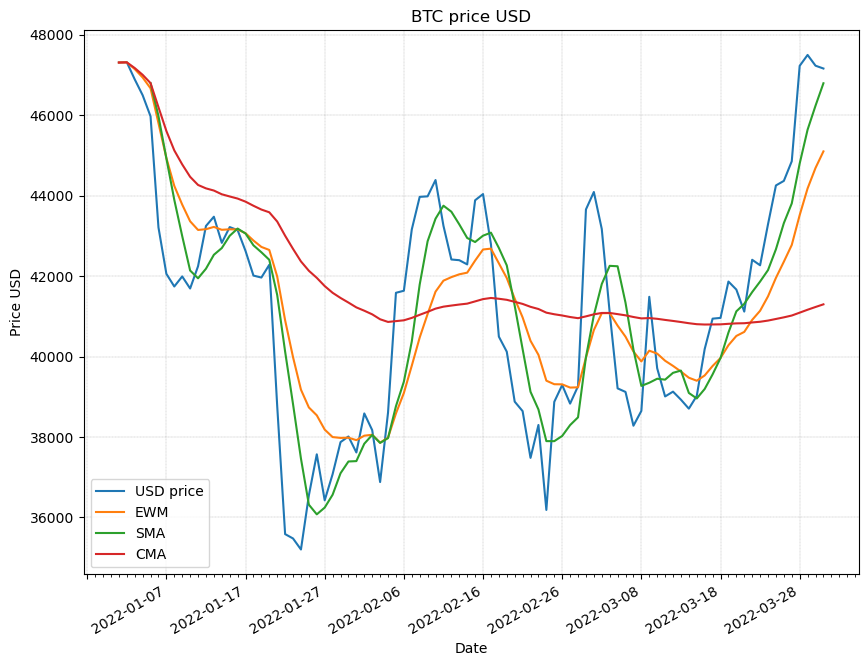

In [31]:
plt.rcParams["figure.figsize"] = (10,8)
plt.title('BTC price USD')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.plot(btc_price['usd_price'])
plt.plot(btc_price['usd_price_ewm'])
plt.plot(btc_price['usd_price_sma'])
plt.plot(btc_price['usd_price_cma'])
plt.legend(['USD price', 'EWM', 'SMA','CMA'])
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.2)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))